Total rows in evaluation_windows: 1764
Unique blackout windows (unique window_id): 441

Top 10 most common blackout_start timestamps:
blackout_start
2015-01-01 00:05:00    408
2015-11-04 05:05:00      6
2015-02-04 00:05:00      6
2015-07-07 05:05:00      3
2015-07-08 05:05:00      3
2015-08-05 05:05:00      3
2015-08-12 05:05:00      3
2015-09-02 05:05:00      3
2015-11-04 10:05:00      3
2015-01-01 05:05:00      3
Name: count, dtype: int64


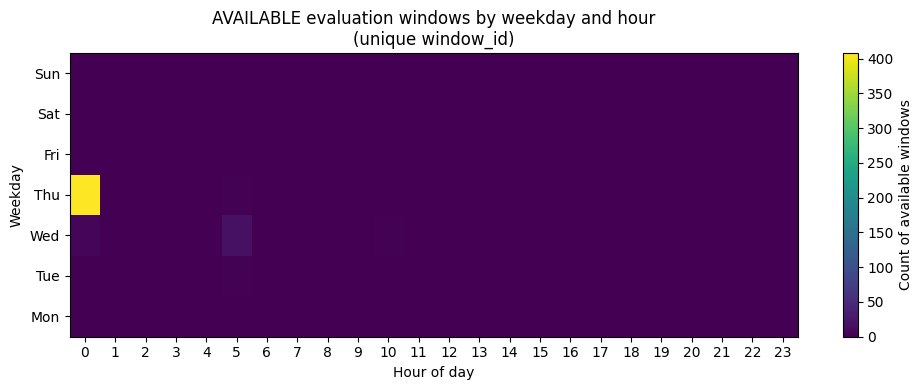

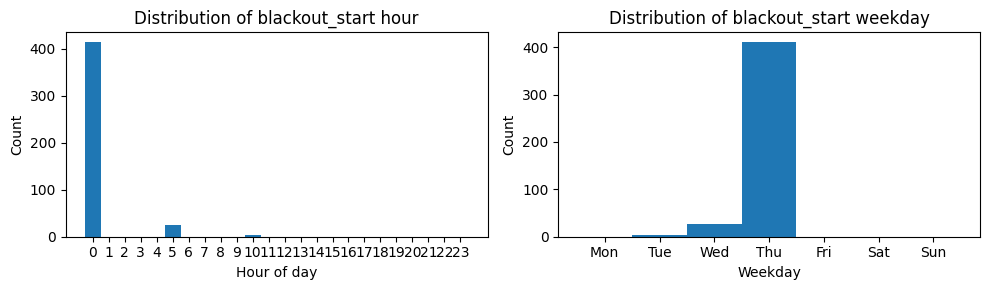

In [1]:
# --- Diagnostic cell: show that evaluation windows are all clustered in time ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import data_interface  # uses evaluation_windows.parquet under the hood

# 1) Load evaluation windows as a DataFrame
eval_obj = data_interface.get_eval_windows("data", as_dataframe=True)

# Just to be safe if it's already a DataFrame vs list-of-dicts:
if isinstance(eval_obj, list):
    eval_df = pd.DataFrame(eval_obj)
else:
    eval_df = eval_obj.copy()

print("Total rows in evaluation_windows:", len(eval_df))

# 2) Collapse to one row per blackout window (ignore multiple horizons)
windows_unique = (
    eval_df
    .drop_duplicates(subset=["window_id"])
    .copy()
)

print("Unique blackout windows (unique window_id):", len(windows_unique))

# 3) Extract weekday / hour for blackout_start
times = pd.to_datetime(windows_unique["blackout_start"])
windows_unique["weekday"] = times.dt.dayofweek  # 0 = Mon, 6 = Sun
windows_unique["hour"] = times.dt.hour

# Show the most common blackout_start timestamps
print("\nTop 10 most common blackout_start timestamps:")
print(
    windows_unique["blackout_start"]
    .value_counts()
    .head(10)
)

# 4) Build weekday × hour count table
heat_counts = (
    windows_unique
    .groupby(["weekday", "hour"])
    .size()
    .unstack("hour")
    .fillna(0)
)

# Ensure all weekdays (0–6) and hours (0–23) are present
all_weekdays = np.arange(7)
all_hours = np.arange(24)
heat_counts = (
    heat_counts
    .reindex(index=all_weekdays, columns=all_hours, fill_value=0)
)

weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# 5) Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(heat_counts.values, aspect="auto", origin="lower")

ax.set_xticks(all_hours)
ax.set_xticklabels(all_hours)
ax.set_yticks(all_weekdays)
ax.set_yticklabels(weekday_labels)

ax.set_xlabel("Hour of day")
ax.set_ylabel("Weekday")
ax.set_title("AVAILABLE evaluation windows by weekday and hour\n(unique window_id)")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Count of available windows")

plt.tight_layout()
plt.show()

# 6) Optional: quick 1D histograms to show collapse
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Histogram by hour
axes[0].hist(windows_unique["hour"], bins=np.arange(25)-0.5)
axes[0].set_xticks(range(24))
axes[0].set_xlabel("Hour of day")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of blackout_start hour")

# Histogram by weekday
axes[1].hist(windows_unique["weekday"], bins=np.arange(8)-0.5)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(weekday_labels)
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of blackout_start weekday")

plt.tight_layout()
plt.show()
